## History of "literature," v1

Ok - over the course of the last two weeks, I've blocked in the code to extract filtered counts for words that appear on pages with "literature." This, combined with the baseline (unfiltered) counts, gives us what we need to perform the simple, co-occurrence analysis - track the diachronic change in a word's association with literature, and find words that have a particularly volatile or "trending" relationship over time.

A high-level view of the data - we're now storing two different types of counts in two tables:

```sql
CREATE TABLE count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year)
);
CREATE TABLE anchored_count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	anchor_count INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year, anchor_count)
);
```

The `count` table store the baseline, unfiltered counts for all words, broken out by year. Eg:

**`"literature" / 1900 / 89608`**

Meaning, "literature" appears 89,608 times in 1900. Meanwhile, `anchored_count` stores counts just for words that appear on pages that "contain" literature, broken out both by year and by the number of times that "literature" appeared on the page in question, which will allow us to dig into the question of whether the surrounding community of words is substantively different on pages that are light / heavy on "literature."

**`"poetry" / 1900 / 4 / 5967`**

Meaning - in 1900, "poetry" appears 5,967 times on pages where "literature" appears 4 times.

In total, the extraction run chewed through all ~820k volumes in the Harvard collection in Hathi, and observed **~43.5 billion** individual tokens:

In [5]:
from hol.models import Count, AnchoredCount

print(Count.total_token_count())

43401065888


Here's the total volume in billions. It's basically a C19 corpus:

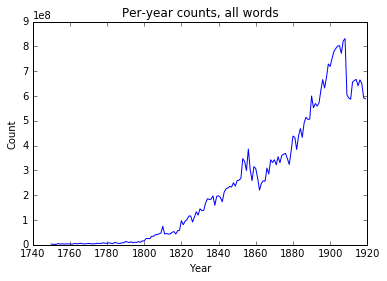

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

years = range(1750, 1920)

ts = Count.year_count_series(years)

plt.title('Per-year counts, all words')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*ts.items()))

## Co-occurrence time series

So, to the real question at hand - what words appear alongside literature at a higher-than-expected rate? There are a couple of ways to get at this - the most common approach is just to use a simple log-likelihood test.

To measure the distinctiveness of "history" in 1900, we can query:

In [7]:
a = AnchoredCount.token_year_count('history', 1900)
print('The number of times "history" appears on pages that contain "literature":')
print(a, '\n')

b = Count.token_year_count('history', 1900)
print('The number of times "history" appears on all pages:')
print(b, '\n')

c = AnchoredCount.year_count(1900)
print('The total number of tokens observed on pages that contain "literature":')
print(c, '\n')

d = Count.year_count(1900)
print('Total number of tokens observed on all pages:')
print(d)

The number of times "history" appears on pages that contain "literature":
39363 

The number of times "history" appears on all pages:
291676 

The total number of tokens observed on pages that contain "literature":
23646454 

Total number of tokens observed on all pages:
719028426 



And then compute the log-likelihood score for "history":

In [8]:
import numpy as np

from scipy.stats import chi2_contingency

g, p, dof, exp = chi2_contingency(
    np.array([[a, b], [c, d]]),
    lambda_='log-likelihood',
)

print(g)

48722.2434646


This is fairly expensive to compute for an individual word, but it can be sped up by querying big batches of counts from the database and calculating the scores in bulk. These get indexed in a `score` table, which just stores the log-likelihood for each word in each year:

```sql
CREATE TABLE score (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	score FLOAT NOT NULL, 
	PRIMARY KEY (token, year)
);
```

Querying against the complete set of ~1.3M log-likelihoods, we can generate a ranked lists that show the words most associated with literature in a given year:

In [9]:
import pprint

from hol.models import Score

topn = Score.topn_by_year(1900, 50)

pp = pprint.PrettyPrinter()
pp.pprint(topn)

OrderedDict([('history', 25.2879182775704),
             ('book', 23.180242433471353),
             ('books', 22.102503149570946),
             ('literary', 20.48003220885534),
             ('english', 20.377727343197332),
             ('i', 19.318189290852953),
             ('vol', 18.90189756722816),
             ('of', 18.73194463089673),
             ('library', 16.420164487183442),
             ('author', 14.657535745634885),
             ('study', 13.262692457088919),
             ('university', 12.575798967421155),
             ('you', 12.0904040205695),
             ('professor', 11.84774214864151),
             ('work', 11.037473673296423),
             ('poetry', 10.538790679796287),
             ('science', 10.312687903154043),
             ('school', 9.937998666607529),
             ('new', 9.196054205933482),
             ('said', 8.982366717874985),
             ('edition', 8.958645403561),
             ('century', 8.907135107799789),
             ('language', 8.858645685

Why does history get a score of 25.2 here, but 48722.2 when calculated directly? This is because the values indexed in the database get scaled to unit variance - centered around 0, with a standard deviation of 1. This is important because the raw log-likelihood scores are boosted up or down by the total volume of tokens, which varies significantly over time. By scaling the scores, we can compare them _across years_, instead of just being able to compare different words within an individual year.

So, now - for any word, we can query a time-series progression that represents the degree to which it tends to appear alongside literature. Eg, for "god" (0 means no association):

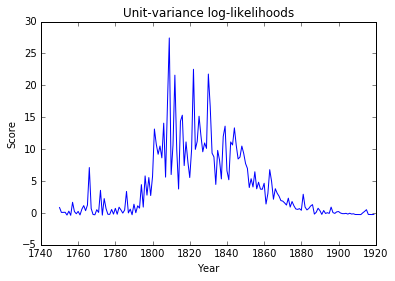

In [10]:
from hol.models import Score

years = range(1750, 1920)

poetry = Score.token_series('god', years)

plt.title('Unit-variance log-likelihoods')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*poetry.items()))

Smoothed with a 10-year window:

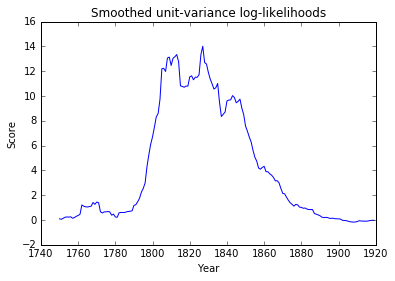

In [11]:
years = range(1750, 1920)

poetry = Score.token_series_smooth('god', years)

plt.title('Smoothed unit-variance log-likelihoods')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*poetry.items()))

Beyond just looking at the progressions for individual words, what we really want is to compare the trends for different words. Which words have the most "volatile" or "trending" signals - moving up and down, slowly approaching or fading over time? How to score the time series in a way that captures this? I think there are a number of different ways to go at this, and different approaches will pick out different things. For example, we could try to capture "peakiness," words that have a baseline value and then spike up or down significantly at one point or another. Or, we could try to find words that have a consistent up or down trend over time - words that gradually but consistently approach literature, or fall away from it.

As a start, though - and since the simplest model is often good, if not best - I just calculated the raw variance of the values in the time series. I think this may actually do a pretty good job of capturing a couple different types of this "dynamism" that we care about. Here are the top 20 words, in terms of variance:

In [13]:
years = range(1750, 1920)

tsv = Score.ranked_series(years)

for token, (series, variance) in list(tsv.items())[:20]:
    print(token, variance)

history 65.6031433824
english 59.1352678638
book 58.3303487405
of 55.7010928629
books 40.7712701957
literary 38.5905314448
vols 33.0374380475
library 24.8801395259
edition 22.7326311625
works 22.0430278869
god 21.5035347413
i 21.3279116504
learning 19.1610184741
poetry 17.6182547175
cloth 16.3690325664
published 15.3261864935
professor 14.682505625
you 11.7778715704
court 11.3829498635
american 10.6920076139


## Trends

A couple of quick observations. Words related to education - the teaching of literature - tend to increase over time:

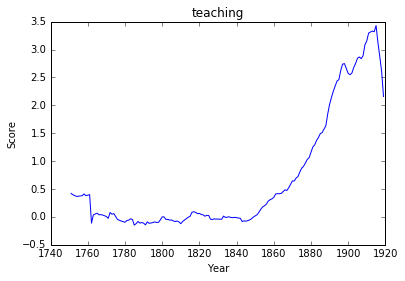

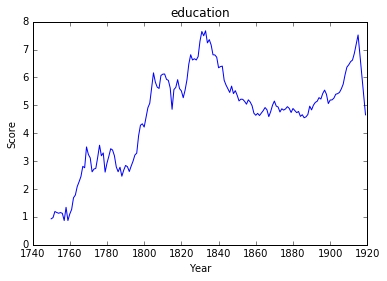

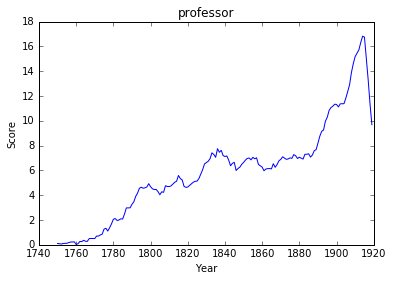

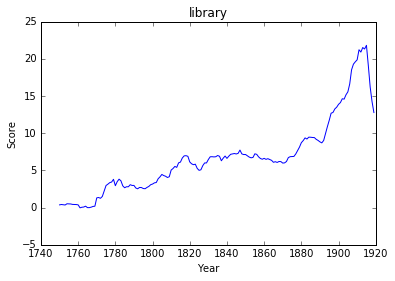

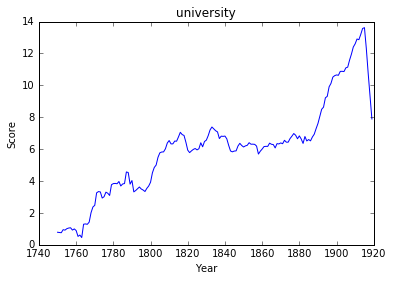

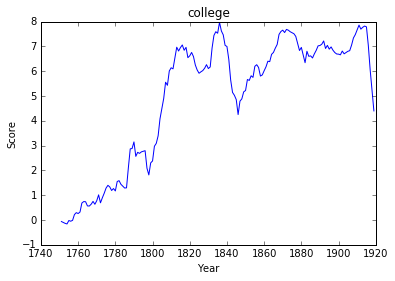

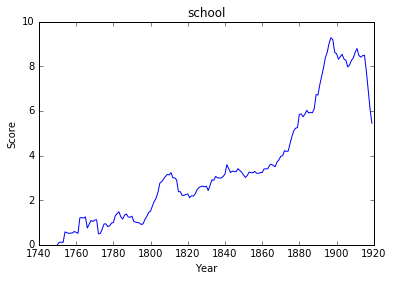

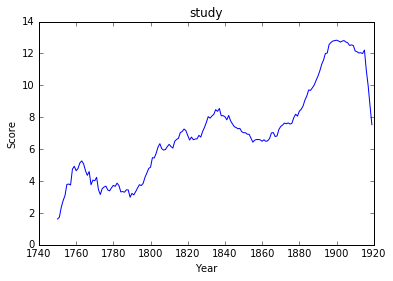

In [27]:
def plot_series(token, series):
    plt.title(token)
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.plot(*zip(*series.items()))
    plt.show()

plot_series('teaching', tsv['teaching'][0])
plot_series('education', tsv['education'][0])
plot_series('professor', tsv['professor'][0])
plot_series('library', tsv['library'][0])
plot_series('university', tsv['university'][0])
plot_series('college', tsv['college'][0])
plot_series('school', tsv['school'][0])
plot_series('study', tsv['study'][0])

But interestingly "learning" and "knowledge" have the opposite trend:

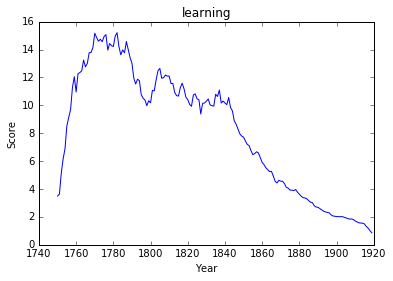

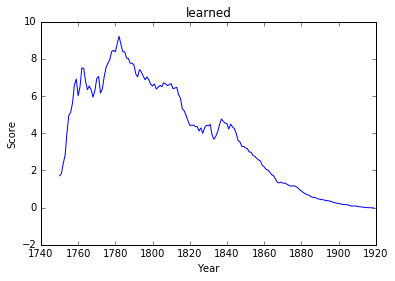

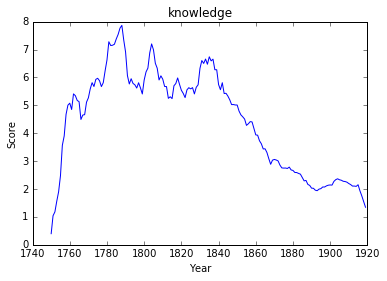

In [26]:
plot_series('learning', tsv['learning'][0])
plot_series('learned', tsv['learned'][0])
plot_series('knowledge', tsv['knowledge'][0])

As if - literature becomes less of a repository of information, of facts, and more of an aesthetic object? Indeed:

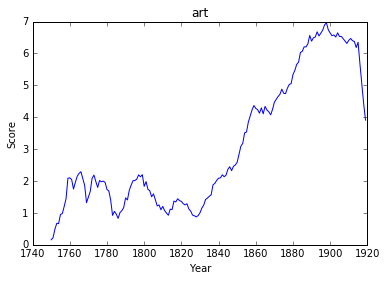

In [24]:
plot_series('art', tsv['art'][0])

And conversely, less "useful" over time:

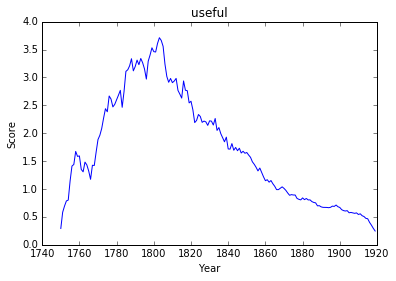

In [50]:
plot_series('useful', tsv['useful'][0])

Other things. Literature becomes feminized in C19?

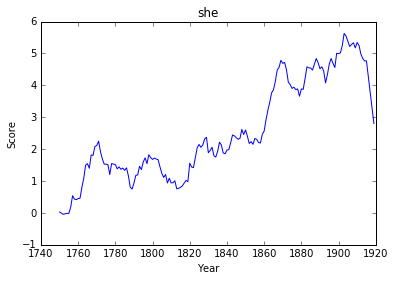

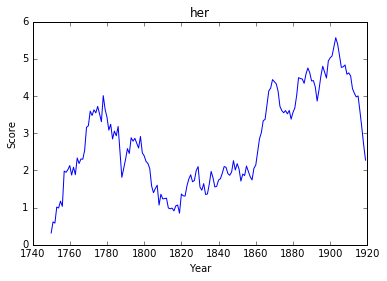

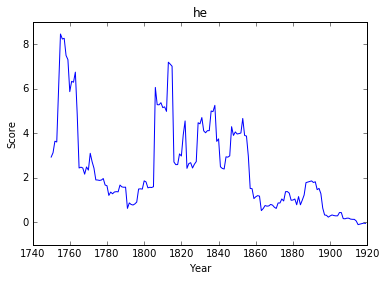

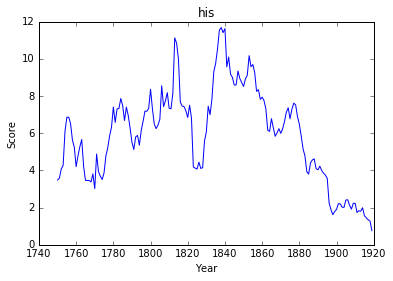

In [31]:
plot_series('she', tsv['she'][0])
plot_series('her', tsv['her'][0])
plot_series('he', tsv['he'][0])
plot_series('his', tsv['his'][0])

Romantic "genius" is well-defined:

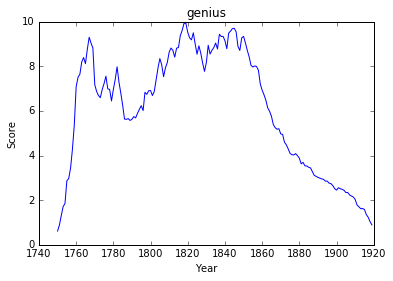

In [36]:
plot_series('genius', tsv['genius'][0])

"God" and "Christ" do well in the first half of the 18th century:

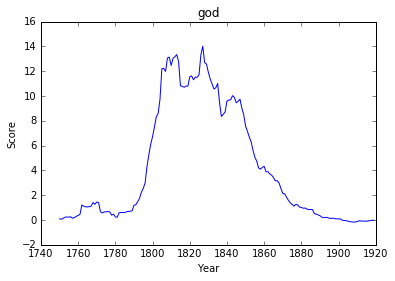

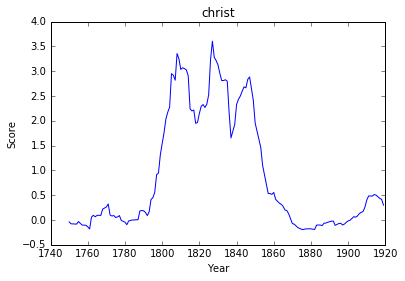

In [34]:
plot_series('god', tsv['god'][0])
plot_series('christ', tsv['christ'][0])

Literature seems to become associated with the judicial system over time:

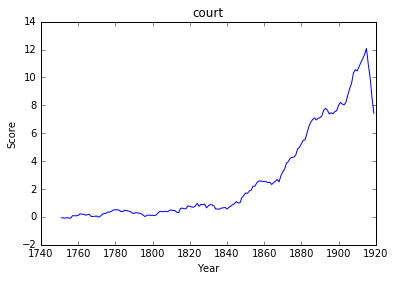

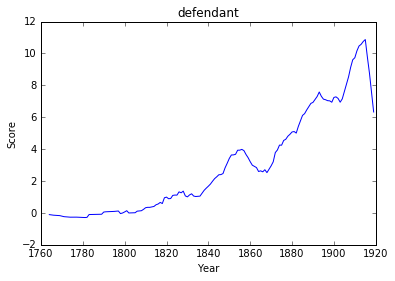

In [40]:
plot_series('court', tsv['court'][0])
plot_series('defendant', tsv['defendant'][0])

And likewise, with business:

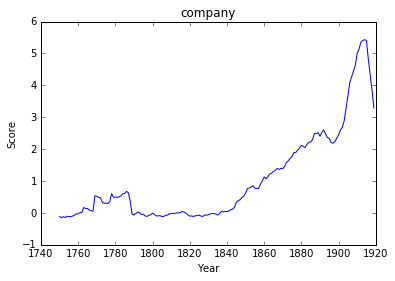

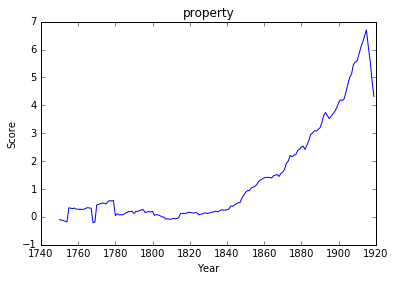

In [48]:
plot_series('company', tsv['company'][0])
plot_series('property', tsv['property'][0])

The literary field becomes more "dialogic"?

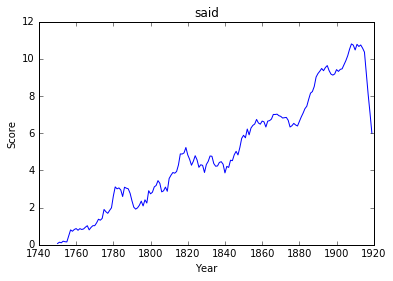

In [41]:
plot_series('said', tsv['said'][0])

What you read becomes less a matter of taste, less of a form of expression?

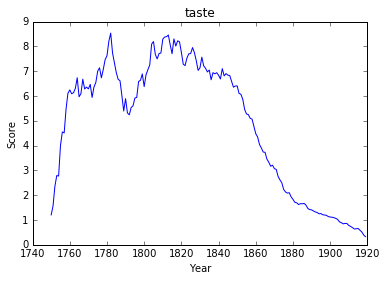

In [43]:
plot_series('taste', tsv['taste'][0])

What in the world is up with "cloth"? Is this something about the history of book binding?

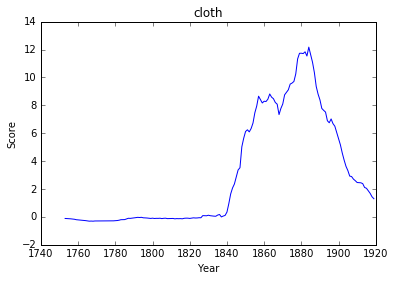

In [42]:
plot_series('cloth', tsv['cloth'][0])

Or "arrived," which I can't even hazard a guess about:

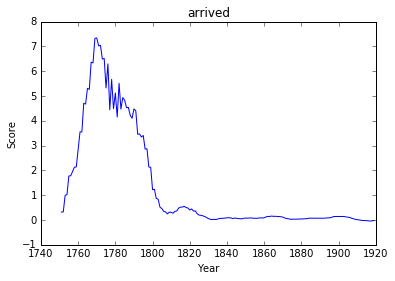

In [44]:
plot_series('arrived', tsv['arrived'][0])

One more - "popularity" peaks out in 1860-1880, and then falls off precipitously:

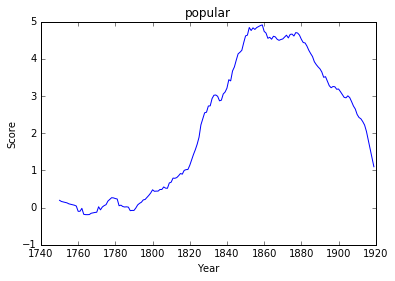

In [52]:
plot_series('popular', tsv['popular'][0])

## Questions, uncertainties

- Why do some stopwords (eg, "of") show up in the MDW lists computed from the log-likelihoods? The lists generally look good to my eye, but this seems odd, and makes me wonder if there's a better approach.

- What's the best way to evaluate the "volatility" of the time series? Can this be significance tested?

- Is it valid to scale the log-likelihoods to unit-variance and then compare across years? I think this works, but it's important to be sure.

- The Harvard collection is very C19 heavy, I think moreso than the rest of Hathi. I'd like to go ahead and run this on the complete corpus.